In [48]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [49]:
import numpy as np
import pandas as pd

In [50]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [51]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [52]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [53]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [54]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [55]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [56]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [60]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Grab last date from selected date range
last_date = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).first()[0]

# Convert object type
entered_date = dt.datetime.strptime(last_date, '%Y-%m-%d')
entered_date = entered_date.date()

# Calculate the date 1 year ago from the last data point in the database
yr_ago = entered_date - dt.timedelta(days=365)
yr_ago

# Perform a query to retrieve the data and precipitation scores
one_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= yr_ago).\
    filter(Measurement.date <= last_date).all()

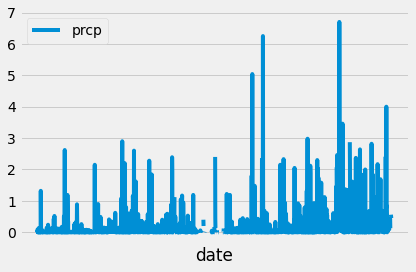

In [61]:
df = pd.DataFrame(one_year_prcp, columns=['date', 'prcp'])
df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.xticks([])
plt.savefig('Images/precipitation.png')
plt.tight_layout()
plt.show()

In [30]:
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [62]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()                             

9

In [63]:
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

active_stations_df = pd.DataFrame(active_stations, columns=['Station', 'Data Count'])
active_stations_df

,Station,Data Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [64]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
most_active_station = active_stations[0][0]

sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]

most_active_station_tobs = session.query(*sel).\
    filter(Measurement.station==most_active_station).all()[0]

print(f"Temperature Minimum: {most_active_station_tobs[0]}")
print(f"Temperature Average: {most_active_station_tobs[1]}")
print(f"Temperature Maximum: {most_active_station_tobs[2]}")

Temperature Minimum: 54.0
Temperature Average: 71.66378066378067
Temperature Maximum: 85.0


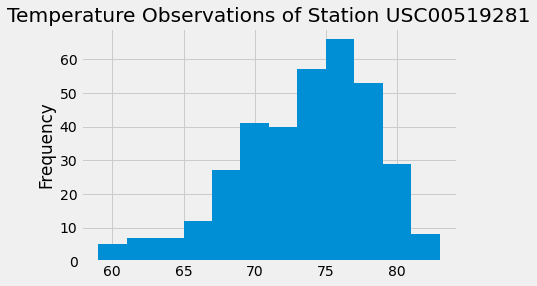

In [65]:
# Choose the station with the highest number of temperature observations.
stn_tobs = session.query(Measurement.tobs).\
    filter(Measurement.date >= yr_ago).\
    filter(Measurement.date <= last_date).\
    filter(Measurement.station==most_active_station).all()

tobs_array = np.ravel(stn_tobs)
tobs_series = pd.Series(tobs_array)

tobs_series.plot.hist(bins=12)
plt.title("Temperature Observations of Station USC00519281")
plt.savefig('Images/station-histogram.png')
plt.show()

## Bonus Challenge Assignment

In [38]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [39]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year_start = dt.date(2018,1,1) - dt.timedelta(days= 365)
# print(prev_year_start)
prev_year_end = prev_year_start + dt.timedelta(days = 5)
#print(prev_year_end)
calc_temp = calc_temps(prev_year_start,prev_year_end)
print(calc_temp)

[(62.0, 68.05714285714286, 74.0)]


In [69]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
ta_temp= list(np.ravel(calc_temp))
#ta_temp
tmin = ta_temp[0]
tmax = ta_temp[2]
temp_avg = ta_temp[1]

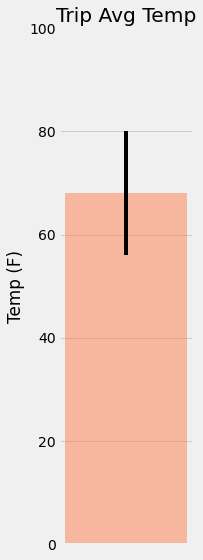

In [70]:
#fig, ax = plt.subplots()
# x = range(0,1)
# print(x)
plt.figure(figsize=(3,8))
plt.bar(1,temp_avg, color = 'coral',alpha = 0.5)
plt.errorbar(1,temp_avg, yerr=(tmax - tmin), color = 'k')
plt.ylim(0, 100)
plt.xticks([])
plt.title('Trip Avg Temp')
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.savefig('Images/temperature.png')

In [47]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_dt = dt.datetime(2017, 6, 10)
end_dt = dt.datetime(2017, 6, 25)

sel = [Measurement.station, func.sum(Measurement.prcp), 
       Station.name, Station.latitude, Station.longitude, 
       Station.elevation]

trip_dates_results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date>=start_dt).\
    filter(Measurement.date<=end_dt).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

trip_df = pd.DataFrame(trip_dates_results, columns=['station', 'prcp', 'name', 'latitude', 'longitude', 'elevation'])
trip_df


,station,prcp,name,latitude,longitude,elevation
0,USC00516128,8.07,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,3.19,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,2.15,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00514830,1.68,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00519523,0.54,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00519397,0.23,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,0.00,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [42]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [71]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

start_date = dt.datetime.strptime('2018-01-01', "%Y-%m-%d")
end_date = dt.datetime.strptime('2018-01-07', "%Y-%m-%d")
#st_str_dt = start_date.strftime("%m-%d")
normals = []
dt_list = []

iter_date = start_date
while iter_date <= end_date:
    dt_list.append(iter_date)
    st_str_dt = iter_date.strftime("%m-%d")
    #print(st_str_dt)
    iter_date += dt.timedelta(1)
    normals.append(*daily_normals(st_str_dt))

#dt_list
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [44]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df2 = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
df2['Date'] = pd.to_datetime(dt_list)
df2.set_index('Date', inplace=True)
df2

,tmin,tavg,tmax
Date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


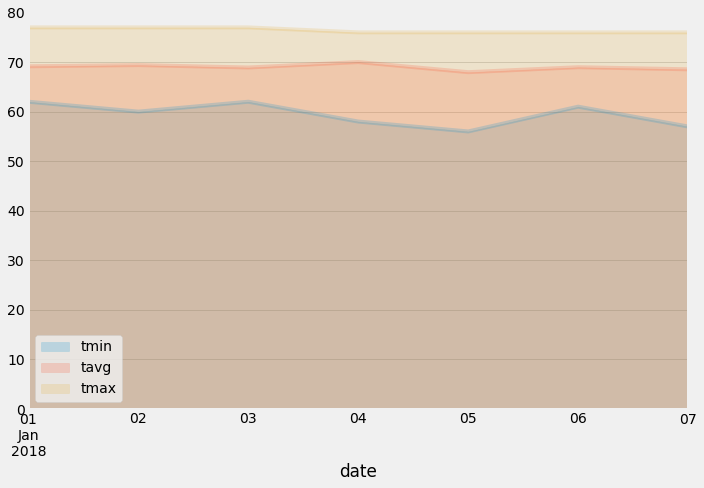

In [72]:
# Plot the daily normals as an area plot with `stacked=False`
df2.plot.area(stacked=False, alpha=0.2,figsize=(10,7))
plt.xlabel("date")
#plt.xticks(df2["Date"], rotation=45)
plt.ylim(0, 80)
plt.tight_layout()
plt.savefig('Images/daily_normals.png')